This notebook descrbies the PORT-EK pipeline analysis of k-mers genreated from the "bat" dataset from [reference to our paper].
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/bat/15mer_indices directory.
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate GISAID data sets, previously downloaded in .fasta files, using the following commands from the main PORT-EK directory:
 - python PORTEKfind.py input/bat/bat.fasta output/bat/[k]mer_indices/ --k [k] --group bat
 - python PORTEKfind.py input/bat/EPI_SET_240422qm.fasta output/bat/[k]mer_indices/ --k [k] --group hum

For the selection of optimal k please see optimal_bat_k_selection.ipynb notebook. 

1. Import necessary libraries and PORT-EK source code:

In [1]:
import sys
import json
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True

2. Declare data set specific definitions and functions:

In [2]:
#PORT-EK parameters
c = 0.5  # This is the conservation thershold used in k-mer rarity filter
m = 2  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers
m_map = 2  # This is the maximum number of mismatches allowed when mapping k-mers to reference genome
l_map = 1000  # This the maximum allowed offset of mapping position from average position of k-mer in samples

#Relative path to k-mer indices
INPUT_PATH = "../output/bat/15mer_indices"

#Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.

FREQ_COLS = ['bat_freq','hum_freq']
AVG_COLS = ['bat_avg','hum_avg',]

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "bat over-represented": ("#870f7e", 1),
    "human over-represented": ("#005ff5", 1),
}
GENE_ORDER_LIST = [
    "orf1ab",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "intergenic",
]
PROTEIN_ORDER_LIST = [
    "nsp1",
    "nsp2",
    "nsp3",
    "nsp4",
    "nsp5",
    "nsp6",
    "nsp7",
    "nsp8",
    "nsp9",
    "nsp10",
    "nsp12",
    "nsp13",
    "nsp14",
    "nsp15",
    "nsp16",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "non-coding",
]


def assign_kmer_type(row):
    if (
        row["bat_err"] > 0
        and row["p-value"] < 0.01
    ):
        return "bat over-represented"
    elif (
        row["bat_err"] < 0
        and row["p-value"] < 0.01
    ):
        return "human over-represented"
    else:
        return "not significant"


def assign_gene(pos):
    if pos in range(266, 21555 + 1):
        gene = "orf1ab"
    elif pos in range(21563, 25384 + 1):
        gene = "S"
    elif pos in range(25393, 26220 + 1):
        gene = "orf3a"
    elif pos in range(26245, 26472 + 1):
        gene = "E"
    elif pos in range(26523, 27191 + 1):
        gene = "M"
    elif pos in range(27202, 27387 + 1):
        gene = "orf6"
    elif pos in range(27394, 27759 + 1):
        gene = "orf7a"
    elif pos in range(27756, 27887 + 1):
        gene = "orf7b"
    elif pos in range(27894, 28259 + 1):
        gene = "orf8"
    elif pos in range(28274, 29533 + 1):
        gene = "N"
    elif pos in range(29558, 29674 + 1):
        gene = "orf10"
    else:
        gene = "intergenic"
    return gene


def assign_protein(pos):
    if pos in range(266, 805 + 1):
        protein = "nsp1"
    elif pos in range(806, 2719 + 1):
        protein = "nsp2"
    elif pos in range(2720, 8554 + 1):
        protein = "nsp3"
    elif pos in range(8555, 10054 + 1):
        protein = "nsp4"
    elif pos in range(10055, 10972 + 1):
        protein = "nsp5"
    elif pos in range(10973, 11842 + 1):
        protein = "nsp6"
    elif pos in range(11843, 12091 + 1):
        protein = "nsp7"
    elif pos in range(12092, 12685 + 1):
        protein = "nsp8"
    elif pos in range(12686, 13024 + 1):
        protein = "nsp9"
    elif pos in range(13025, 13441 + 1):
        protein = "nsp10"
    elif pos in range(13442, 16236 + 1):
        protein = "nsp12"
    elif pos in range(16237, 18039 + 1):
        protein = "nsp13"
    elif pos in range(18040, 19620 + 1):
        protein = "nsp14"
    elif pos in range(19621, 20658 + 1):
        protein = "nsp15"
    elif pos in range(20659, 21555 + 1):
        protein = "nsp16"
    elif pos in range(21563, 25384 + 1):
        protein = "S"
    elif pos in range(25393, 26220 + 1):
        protein = "orf3a"
    elif pos in range(26245, 26472 + 1):
        protein = "E"
    elif pos in range(26523, 27191 + 1):
        protein = "M"
    elif pos in range(27202, 27387 + 1):
        protein = "orf6"
    elif pos in range(27394, 27759 + 1):
        protein = "orf7a"
    elif pos in range(27756, 27887 + 1):
        protein = "orf7b"
    elif pos in range(27894, 28259 + 1):
        protein = "orf8"
    elif pos in range(28274, 29533 + 1):
        protein = "N"
    elif pos in range(29558, 29674 + 1):
        protein = "orf10"
    else:
        protein = "non-coding"
    return protein

3. Construct k-mer count matrix and apply rarity filter

In [3]:
kmer_set = set()
sample_list = []
in_path = pathlib.Path(INPUT_PATH).glob('**/*')

for filename in in_path:
    sample_list.append(filename.stem)
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    kmer_set.update(temp_dict.keys())

all_kmer_matrix = pd.DataFrame(0, index=list(kmer_set), columns=sample_list, dtype="uint8")
bat_sample_idx = [sample for sample in all_kmer_matrix.columns if "bat" in sample]
hum_sample_idx = [sample for sample in all_kmer_matrix.columns if "hum" in sample]

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")

counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(INPUT_PATH).glob('**/*')

for filename in in_path:
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    count_dict = {f"{filename.stem}":[len(pos) for pos in temp_dict.values()]}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(f"Completed {filename.stem}. {counter} of {tot_files} indices done.", end="\r", flush=True)
    counter += 1

bin_kmer_matrix = all_kmer_matrix > 0
all_kmer_matrix['bat_freq'] = bin_kmer_matrix.loc[:,bat_sample_idx].mean(axis=1)
all_kmer_matrix['hum_freq'] = bin_kmer_matrix.loc[:,hum_sample_idx].mean(axis=1)
all_kmer_matrix['bat_avg'] = all_kmer_matrix.loc[:,bat_sample_idx].mean(axis=1)
all_kmer_matrix['hum_avg'] = all_kmer_matrix.loc[:,hum_sample_idx].mean(axis=1)
del bin_kmer_matrix

if 'AAAAAAAAAAAAAAA' in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop('AAAAAAAAAAAAAAA')

common_kmer_matrix = portek.filter_kmers(all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c)

print(f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}.")


Imported 1442011 kmers and 2344 samples.
Completed hum_EPI_ISL_402128. 2344 of 2344 indices done...
32566 common k-mers remaining after filtering at a threshold of 0.5.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [12]:
common_kmer_matrix['bat_err'] = common_kmer_matrix['bat_avg']-common_kmer_matrix['hum_avg']
common_kmer_matrix['bat_RMSE'] =  np.sqrt((common_kmer_matrix['bat_err']**2)/2)
common_kmer_matrix['seq'] = common_kmer_matrix.index
common_kmer_matrix['p-value'] = common_kmer_matrix['seq'].apply(portek.calc_kmer_pvalue,args=(bat_sample_idx, hum_sample_idx, common_kmer_matrix))
common_kmer_matrix = common_kmer_matrix.sort_values('bat_RMSE',ascending=False)
common_kmer_matrix = common_kmer_matrix.drop('seq', axis=1)
common_kmer_matrix['-log10_p-value'] = -np.log10(common_kmer_matrix['p-value'])
common_kmer_matrix['group'] = common_kmer_matrix.apply(assign_kmer_type, axis=1)
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)
bat_overrep = common_kmer_matrix[common_kmer_matrix['group'] == 'bat over-represented']
human_overrep = common_kmer_matrix[common_kmer_matrix['group'] == 'human over-represented']

print(f"{len(bat_overrep)} bat over-represented k-mers and {len(human_overrep)} human over-represented k-mers found.")

/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


2744 bat over-represented k-mers and 29822 human over-represented k-mers found.


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [13]:
# common_kmer_matrix.to_csv("output/bat/common_15mer_count_matrix.csv")
# common_kmer_stat_matrix.to_csv("output/bat/common_15mer_stat_matrix.csv")
# all_kmer_matrix.to_csv("output/bat/all_15mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv('output/bat/common_15mer_count_matrix.csv', index_col=0)
# all_kmer_matrix = pd.read_csv('output/bat/all_15mer_count_matrix.csv', index_col=0)
# common_kmer_stat_matrix = pd.read_csv("output/bat/common_15mer_stat_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

Text(0, 0.5, '-log10 of p-value')

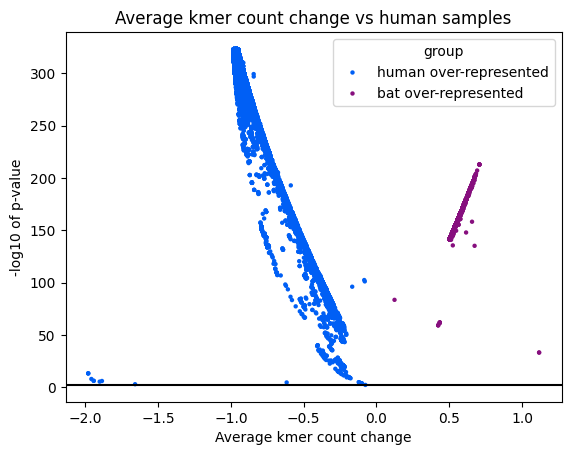

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(data=common_kmer_matrix, x='bat_err', y = '-log10_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.set_title('Average kmer count change vs human samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
# plt.savefig("output/bat/15mers_change_vs_p.svg", dpi = 600, format = "svg")

6. Optionally re-examine rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [15]:
bat_overrep_rare = all_kmer_matrix.loc[(all_kmer_matrix['bat_avg'] == all_kmer_matrix[AVG_COLS].max(axis=1))]
bat_overrep_rare = bat_overrep_rare[~bat_overrep_rare.index.isin(bat_overrep.index)]

#Comment the following line to avoid lengthy k-mer similarity graph calculation
bat_overrep_similarity_graph = portek.build_similarity_graph_two_list(bat_overrep.index.tolist(), bat_overrep_rare.index.tolist(),m)

#Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"output/bat/bor_15mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(bat_overrep_similarity_graph, out_file)

# with open(f"output/bat/bor_15mer_{m}m.pickle", mode = "rb") as in_file:
#     bat_overrep_similarity_graph = pickle.load(in_file)

bat_overrep_rare = bat_overrep_rare[bat_overrep_rare.index.isin(bat_overrep_similarity_graph.nodes)]

bat_overrep_rare['bat_err'] = bat_overrep_rare['bat_avg']-bat_overrep_rare['hum_avg']
bat_overrep_rare['bat_RMSE'] =  np.sqrt((bat_overrep_rare['bat_err']**2)/2)
bat_overrep_rare['seq'] = bat_overrep_rare.index
bat_overrep_rare['p-value'] = bat_overrep_rare['seq'].apply(portek.calc_kmer_pvalue,args=(bat_sample_idx, hum_sample_idx, bat_overrep_rare))
bat_overrep_rare = bat_overrep_rare.sort_values('bat_RMSE',ascending=False)
bat_overrep_rare = bat_overrep_rare.drop('seq', axis=1)
bat_overrep_rare['-log10_p-value'] = -np.log10(bat_overrep_rare['p-value'])
bat_overrep_rare['group'] = bat_overrep_rare.apply(assign_kmer_type, axis=1)
bat_overrep_rare  = bat_overrep_rare[bat_overrep_rare['group'] == 'bat over-represented']
bat_overrep_all = pd.concat([bat_overrep_rare, bat_overrep])

In [ ]:
human_overrep_rare = all_kmer_matrix.loc[(all_kmer_matrix['bat_avg'] == all_kmer_matrix[AVG_COLS].min(axis=1))]
human_overrep_rare = human_overrep_rare[~human_overrep_rare.index.isin(human_overrep.index)]

#Comment the following line to avoid lengthy k-mer similarity graph calculation
human_overrep_similarity_graph = portek.build_similarity_graph_two_list(human_overrep.index.tolist(), human_overrep_rare.index.tolist(),m)

#Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"output/bat/hor_15mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(human_overrep_similarity_graph, out_file)

# with open(f"output/bat/hor_15mer_{m}m.pickle", mode = "rb") as in_file:
#     human_overrep_similarity_graph = pickle.load(in_file)

human_overrep_rare = human_overrep_rare[human_overrep_rare.index.isin(human_overrep_similarity_graph.nodes)]

human_overrep_rare['bat_err'] = human_overrep_rare['bat_avg']-human_overrep_rare['hum_avg']
human_overrep_rare['bat_RMSE'] =  np.sqrt((human_overrep_rare['bat_err']**2)/2)
human_overrep_rare['seq'] = human_overrep_rare.index
human_overrep_rare['p-value'] = human_overrep_rare['seq'].apply(portek.calc_kmer_pvalue,args=(bat_sample_idx, hum_sample_idx, human_overrep_rare))
human_overrep_rare = human_overrep_rare.sort_values('bat_RMSE',ascending=False)
human_overrep_rare = human_overrep_rare.drop('seq', axis=1)
human_overrep_rare['-log10_p-value'] = -np.log10(human_overrep_rare['p-value'])
human_overrep_rare['group'] = human_overrep_rare.apply(assign_kmer_type, axis=1)
human_overrep_rare  = human_overrep_rare[human_overrep_rare['group'] == 'human over-represented']
human_overrep_all = pd.concat([human_overrep_rare, human_overrep])

/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [ ]:
# Uncomment this block if you didn't re-examine the rare k-mers
# bat_enriched = bat_overrep[bat_overrep['bat_RMSE']>min_RMSE]
# human_enriched = human_overrep[human_overrep['bat_RMSE']>min_RMSE]

# Comment this block if you didn't re-examine the rare k-mers 
bat_enriched = bat_overrep_all[bat_overrep['bat_RMSE']>min_RMSE]
human_enriched = human_overrep_all[human_overrep['bat_RMSE']>min_RMSE]

print(f"{len(bat_enriched)} bat enriched k-mers and {len(human_enriched)} human enriched k-mers found.")


def assign_host_numerical(sample_id):
    if sample_id in bat_sample_idx:
        host = 1
    else:
        host = 0
    return host


counts_for_classifier = pd.concat([bat_enriched, human_enriched]).T
counts_for_classifier.drop(common_kmer_stat_matrix.columns, axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv("../output/bat/15mer_counts_for_classifier.csv")

2984 bat enriched k-mers and 244 human enriched k-mers found.


OSError: Cannot save file into a non-existent directory: 'output/bat'

8. Map enriched k-mers to the reference genome and identify host-enriched mutations.